In [1]:
%load_ext autoreload

In [13]:
from certified_iris_generator import CertifiedIrisRegionGenerator
import sys
import os
import time
import numpy as np
from functools import partial
import itertools
import iris_utils #TODO remove
import ipywidgets as widgets
from IPython.display import display
from meshcat import Visualizer

In [14]:
#pydrake imports
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import MultibodyPlant, AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.all import InverseKinematics, RevoluteJoint, RationalForwardKinematics
from pydrake.geometry.optimization import IrisOptionsRationalSpace, IrisInRationalConfigurationSpace, HPolyhedron, Hyperellipsoid
from pydrake.geometry import Role
import pydrake.symbolic as sym
from pydrake.all import MathematicalProgram, RigidTransform, RollPitchYaw
from pydrake.systems.meshcat_visualizer import ConnectMeshcatVisualizer
from sandbox import rrtiris

In [15]:
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])
vis = Visualizer(zmq_url=zmq_url)
vis.delete()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7025/static/


In [16]:

def load_model():
    model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")
    S_C_H_U_N_K = FindResourceOrThrow("drake/sos_iris_certifier/schunk_wsg_50_block.sdf")
    box_file_1 = FindResourceOrThrow("drake/sos_iris_certifier/assets/shelves.sdf")
    box_file_2 = FindResourceOrThrow("drake/sos_iris_certifier/assets/shelves2.sdf")
    box_file_3 = FindResourceOrThrow("drake/sos_iris_certifier/assets/shelves3.sdf")
    box_file_4 = FindResourceOrThrow("drake/sos_iris_certifier/assets/shelves4.sdf")
    lid_file = FindResourceOrThrow("drake/sos_iris_certifier/assets/lid.urdf")
    ground_file = FindResourceOrThrow("drake/sos_iris_certifier/assets/ground.urdf")

    models =[]

    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)

    parser = Parser(plant, scene_graph)
    parser.package_map().Add( "wsg_50_description", os.path.dirname(FindResourceOrThrow(
            "drake/manipulation/models/wsg_50_description/package.xml")))
    models.append(parser.AddModelFromFile(model_file))
    models.append(parser.AddModelFromFile(box_file_1))
    models.append(parser.AddModelFromFile(box_file_2))
    models.append(parser.AddModelFromFile(box_file_3))
    models.append(parser.AddModelFromFile(box_file_4))
    models.append(parser.AddModelFromFile(lid_file))
    models.append(parser.AddModelFromFile(ground_file))
    models.append(parser.AddModelFromFile(S_C_H_U_N_K))

    sp = 0.4
    x_fac = 1.2
    locs = [ [0,0,0], 
            [x_fac*sp, 1.4*sp,0.4], [x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,1.4*sp,0.4], 
            [0.0 ,0 , 0.95], [0.0 ,0 , -0.05]] 
    idx = 0
    for model in models[:-1]:
        plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), RigidTransform(locs[idx]))
        idx +=1
    
    #fuse S_C_H_U_N_K
    plant.WeldFrames(plant.get_body(plant.GetBodyIndices(models[0])[-1]).body_frame(),
                     plant.get_body(plant.GetBodyIndices(models[-1])[0]).body_frame(),
                     RigidTransform(RollPitchYaw([np.pi/2,0, np.pi/2]).ToRotationMatrix(),[0,0,0.114]))

    plant.Finalize()
    return plant, builder, scene_graph, models

def load_vis(plant, builder, scene_graph, zmq_url, col_geom = 0):
    vis = Visualizer(zmq_url=zmq_url)
    vis.delete()
    if col_geom == 0:
        viz_role = Role.kIllustration
    else:
        viz_role = Role.kProximity
    visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False, role=viz_role )

    diagram = builder.Build()
    visualizer.load()
    return vis, diagram
plant, builder, scene_graph, models = load_model()
vis, diagram = load_vis(plant, builder, scene_graph, zmq_url, col_geom = 1)
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
diagram.Publish(context)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7025/static/
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6025...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7025/static/
Connected to meshcat-server.


In [18]:
import ipywidgets as widgets
from IPython.display import display
q_slider = np.zeros((7,))
sliders = []
for low, up, joint_idx in zip(plant.GetPositionLowerLimits()[:7], plant.GetPositionUpperLimits()[:7], range(7)):
    sliders.append(
        widgets.FloatSlider(
        min=low, 
        max=up, 
        value=0, 
        description=f'iiwa_joint_{joint_idx}'
        )
    )


def handle_slider_change(change, idx):
    q_slider[idx] = change['new']
    #print(q, end="\r")
    plant.SetPositions(plant_context, q_slider)
    diagram.Publish(context)
    

for idx, slider in enumerate(sliders):
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='iiwa_joint_0', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_1', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_2', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_3', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_4', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_5', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_6', max=3.05433, min=-3.05433)

In [19]:
display(vis.jupyter_cell())

In [20]:
start = np.array([1.43, -0.69, 0.83, 1.01, -1.97, 1.11, np.pi/2])
target = np.array([ 1.63294,  1.3056 ,  0.43   , -1.19   , -1.76706, -1.0944 ,
       -2.45433])
plant.SetPositions(plant_context, start)
diagram.Publish(context)

In [21]:
rational_fk = RationalForwardKinematics(plant)
iris_options = IrisOptionsRationalSpace()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 20
iris_options.configuration_space_margin = 0.8e-5
iris_options.max_faces_per_collision_pair = 10
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.01
iris_options.enable_ibex = False
iris_options.certify_region_with_sos_during_generation = False
iris_options.certify_region_with_sos_after_generation = False

poi = []
for pt in [start, target]:
    poi.append(rational_fk.ComputeTValue(pt, np.zeros((7,)) ))

#compute limits in t-space
limits_t = []
for q in [plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits()]:
    limits_t.append(rational_fk.ComputeTValue(np.array(q), np.zeros((7,)) ))
    
starting_poly = HPolyhedron.MakeBox(limits_t[0], limits_t[1])

def iris_handle(seed, domain):
    seed_q = rational_fk.ComputeQValue(np.array(seed), np.zeros((7,)) )
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context), seed_q)
    return IrisInRationalConfigurationSpace(plant, plant.GetMyContextFromRoot(context),
                                              iris_options, domain)

In [22]:
plant.SetPositions(plant_context, start)
diagram.Publish(context)

In [23]:
ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)

def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)

In [24]:
RRTIRIS = rrtiris.RRTIRIS(poi[0],
                          poi[1],
                          limits = limits_t,
                          default_iris_domain = starting_poly,
                          iris_handle = iris_handle,
                          offset_scaler = 0.8,
                          init_goal_sample_rate = 0.05,
                          goal_sample_rate_scaler = 0.1,
                          verbose = True,
                          plotcallback = None,
                          )
RRTIRIS.run(1)

0
[RRT IRIS] Pos_samp [10.63247989 -0.58219511  2.40197317  1.62714291  0.13028986  0.50895084
 -8.31145573]  seed  [ 0.19362184 -0.22399228  0.92292637  1.36950165 -0.35053052  0.21743532
 -2.21275537]  dist  12.200915568519141
1.8298078051217046
[RRT IRIS] it: 0 distance to target:  1.830 goalsample prob:  0.317


(False,
  <pydrake.geometry.optimization.Hyperellipsoid at 0x7f000395f0b0>])

In [13]:
regions = RRTIRIS.node_regions

In [25]:
editted_regions = []
filtered_collision_pairs = set()

binary_search_options = rational_fk.BinarySearchOption()
binary_search_options.epsilon_max = 10
binary_search_options.epsilon_min = -.2
binary_search_options.max_iters = 5
binary_search_options.search_d = True

bilinear_alternation_option = rational_forward_kinematics.BilinearAlternationOption()
bilinear_alternation_option.max_iters = 20
bilinear_alternation_option.lagrangian_backoff_scale = 1e-3
bilinear_alternation_option.polytope_backoff_scale = 1e-5

solver_options = mp.SolverOptions()
for r in regions: 
    try:
        d_feasible = \
            cspace_free_region.CspacePolytopeBinarySearch(
                iris_options.q_star, filtered_collision_pairs, r.A(), r.b(),
                binary_search_options, solver_options)
        C_final, d_final, P_final, q_final = \
            cspace_free_region.CspacePolytopeBilinearAlternation(
                iris_options.q_star, filtered_collision_pairs, r.A(), d_feasible,
                bilinear_alternation_option, solver_options)
        C_final = np.vstack([C_final, P_joint_limits.A()])
        d_final = np.concatenate([d_final, P_joint_limits.b()])
        editted_regions.append(HPolyhedron(C_final, d_final))
    except Exception as e:
        print(e)
print(len(editted_regions))

AttributeError: 'pydrake.multibody.rational_forward_kinematics.Rati' object has no attribute 'BinarySearchOption'

In [ ]:
rational_fk

In [14]:
iris_kwargs = {
    'iris_starting_ellipse_vol': 1e-5,
    'iris_plane_pullback': 1e-4,
    'iris_max_faces': -1
}

iris_generator = CertifiedIrisRegionGenerator(diagram, plant, scene_graph, **iris_kwargs)

In [ ]:
iris_generator.regions = RRTIRIS.node_regions
iris_generator.seed_points = np.array(RRTIRIS.seed_points)


iris_generator.initalize_certifier(plane_order = 1, strict_pos_tol = 1e-4)

In [50]:
np.array(RRTIRIS.seed_points).shape

(4, 7)

In [57]:
RRTIRIS.node_ellipses[0].Volume()

839734.6535611398

In [22]:
col_func_handle(poi[0])

1.0

In [21]:
poi[0]

array([ 0.86826021, -0.35937254,  0.44058872,  0.55281256, -1.50719422,
        0.62000592,  1.        ])

In [10]:
vis = Visualizer(zmq_url=zmq_url)
vis.delete()

#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/urdf/iiwa14_polytope_collision.urdf")
model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")

#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf")
#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf")

#box_file = FindResourceOrThrow("drake/sandbox/assets/box.urdf")
box_file_1 = FindResourceOrThrow("drake/sandbox/assets/shelves.sdf")
box_file_2 = FindResourceOrThrow("drake/sandbox/assets/shelves2.sdf")
box_file_3 = FindResourceOrThrow("drake/sandbox/assets/shelves3.sdf")
box_file_4 = FindResourceOrThrow("drake/sandbox/assets/shelves4.sdf")
lid_file = FindResourceOrThrow("drake/sandbox/assets/lid.urdf")
ground_file = FindResourceOrThrow("drake/sandbox/assets/ground.urdf")

models =[]

builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
models.append(Parser(plant, scene_graph).AddModelFromFile(model_file))

models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_1))
models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_2))
models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_3))
models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_4))
models.append(Parser(plant, scene_graph).AddModelFromFile(lid_file))
models.append(Parser(plant, scene_graph).AddModelFromFile(ground_file))

sp = 0.4
x_fac = 1.2
locs = [ [0,0,0], 
        [x_fac*sp, 1.4*sp,0.4], [x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,1.4*sp,0.4], 
        [0.0 ,0 , 0.95], [0.0 ,0 , -0.05]] 
idx = 0
for model in models:
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), RigidTransform(locs[idx]))
    idx +=1
    
    
plant.Finalize()

visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False, )

diagram = builder.Build()
visualizer.load()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
diagram.Publish(context)



You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


In [11]:
sliders = []
for joint_idx in range(1,8):
    sliders.append(
        widgets.FloatSlider(
        min=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit(), 
        max=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit(), 
        value=0, 
        description=f'iiwa_joint_{joint_idx}'
        )
    )

ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)

def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
    
def showres(q):
    for joint_idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{joint_idx}").set_angle(plant_context, q[joint_idx-1])
    col = col_func_handle(q)
    if col:
        vis["collision"].set_object(
                meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0xFF0000))
        vis["collision"].set_transform(
                meshcat.transformations.translation_matrix([0, 1.0, 1.0]))
    else:
        vis["collision"].set_object(
                meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0x00FF00))
        vis["collision"].set_transform(
                meshcat.transformations.translation_matrix([0, 1.0, 1.0]))
    diagram.Publish(context)
    print("              ", end = "\r")
    print(col , end = "\r")

    
def set_joint_angles(vals):
    for idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{idx}").set_angle(plant_context, vals[idx-1])
    
    
    
q_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# q_start = [-1.37, -1.39, -1.57, -1.19, -1.57, 0.00, 0.00]
# q_end = [1.53, -1.19, 1.83, 0.91, -1.27, -0.59, 0.00]
q = q_init.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    #print(q, end="\r")
    showres(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1


In [5]:
for slider in sliders:
    display(slider)
display(vis.jupyter_cell())

FloatSlider(value=0.0, description='iiwa_joint_1', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_2', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_3', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_4', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_5', max=2.96706, min=-2.96706)

FloatSlider(value=0.0, description='iiwa_joint_6', max=2.0944, min=-2.0944)

FloatSlider(value=0.0, description='iiwa_joint_7', max=3.05433, min=-3.05433)

In [12]:
#problem config
start = np.array([1.43, -0.69, 0.83, 1.01, -1.97, 1.11, 0.00])
target = np.array([1.73, 1.41, 0.43, -1.19, -1.27, -1.19, 0.00])
showres(start)
limits =[plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits()]

In [7]:
showres(target)

In [86]:
showres(np.zeros(7))

In [21]:
PRM = prm.PRM( 
            limits,
            num_points = 100000,
            col_func_handle = col_func_handle,
            num_neighbours = 10, 
            dist_thresh = 1.0,
            num_col_checks = 10,
            verbose = True,
            plotcallback = None
            )

PRM.add_start_end(start, target)
prm_path, _ = PRM.find_shortest_path()
print(f'PRM path length: {len(prm_path)}')

[PRM] Samples 0
[PRM] Samples 30
[PRM] Samples 60
[PRM] Samples 90
[PRM] Samples 120
[PRM] Samples 150
[PRM] Samples 180
[PRM] Samples 210
[PRM] Samples 240
[PRM] Samples 270
[PRM] Samples 300
[PRM] Samples 330
[PRM] Samples 360
[PRM] Samples 390
[PRM] Samples 420
[PRM] Samples 450
[PRM] Samples 480
[PRM] Samples 510
[PRM] Samples 540
[PRM] Samples 570
[PRM] Samples 600
[PRM] Samples 630
[PRM] Samples 660
[PRM] Samples 690
[PRM] Samples 720
[PRM] Samples 750
[PRM] Samples 780
[PRM] Samples 810
[PRM] Samples 840
[PRM] Samples 870
[PRM] Samples 900
[PRM] Samples 930
[PRM] Samples 960
[PRM] Samples 990
[PRM] Samples 1020
[PRM] Samples 1050
[PRM] Samples 1080
[PRM] Samples 1110
[PRM] Samples 1140
[PRM] Samples 1170
[PRM] Samples 1200
[PRM] Samples 1230
[PRM] Samples 1260
[PRM] Samples 1290
[PRM] Samples 1320
[PRM] Samples 1350
[PRM] Samples 1380
[PRM] Samples 1410
[PRM] Samples 1440
[PRM] Samples 1470
[PRM] Samples 1500
[PRM] Samples 1530
[PRM] Samples 1560
[PRM] Samples 1590
[PRM] Samples

[PRM] Samples 13620
[PRM] Samples 13650
[PRM] Samples 13680
[PRM] Samples 13710
[PRM] Samples 13740
[PRM] Samples 13770
[PRM] Samples 13800
[PRM] Samples 13830
[PRM] Samples 13860
[PRM] Samples 13890
[PRM] Samples 13920
[PRM] Samples 13950
[PRM] Samples 13980
[PRM] Samples 14010
[PRM] Samples 14040
[PRM] Samples 14070
[PRM] Samples 14100
[PRM] Samples 14130
[PRM] Samples 14160
[PRM] Samples 14190
[PRM] Samples 14220
[PRM] Samples 14250
[PRM] Samples 14280
[PRM] Samples 14310
[PRM] Samples 14340
[PRM] Samples 14370
[PRM] Samples 14400
[PRM] Samples 14430
[PRM] Samples 14460
[PRM] Samples 14490
[PRM] Samples 14520
[PRM] Samples 14550
[PRM] Samples 14580
[PRM] Samples 14610
[PRM] Samples 14640
[PRM] Samples 14670
[PRM] Samples 14700
[PRM] Samples 14730
[PRM] Samples 14760
[PRM] Samples 14790
[PRM] Samples 14820
[PRM] Samples 14850
[PRM] Samples 14880
[PRM] Samples 14910
[PRM] Samples 14940
[PRM] Samples 14970
[PRM] Nodes connected: 0
[PRM] Nodes connected: 20
[PRM] Nodes connected: 40
[PR

[PRM] Nodes connected: 5240
[PRM] Nodes connected: 5260
[PRM] Nodes connected: 5280
[PRM] Nodes connected: 5300
[PRM] Nodes connected: 5320
[PRM] Nodes connected: 5340
[PRM] Nodes connected: 5360
[PRM] Nodes connected: 5380
[PRM] Nodes connected: 5400
[PRM] Nodes connected: 5420
[PRM] Nodes connected: 5440
[PRM] Nodes connected: 5460
[PRM] Nodes connected: 5480
[PRM] Nodes connected: 5500
[PRM] Nodes connected: 5520
[PRM] Nodes connected: 5540
[PRM] Nodes connected: 5560
[PRM] Nodes connected: 5580
[PRM] Nodes connected: 5600
[PRM] Nodes connected: 5620
[PRM] Nodes connected: 5640
[PRM] Nodes connected: 5660
[PRM] Nodes connected: 5680
[PRM] Nodes connected: 5700
[PRM] Nodes connected: 5720
[PRM] Nodes connected: 5740
[PRM] Nodes connected: 5760
[PRM] Nodes connected: 5780
[PRM] Nodes connected: 5800
[PRM] Nodes connected: 5820
[PRM] Nodes connected: 5840
[PRM] Nodes connected: 5860
[PRM] Nodes connected: 5880
[PRM] Nodes connected: 5900
[PRM] Nodes connected: 5920
[PRM] Nodes connecte

[PRM] Nodes connected: 11060
[PRM] Nodes connected: 11080
[PRM] Nodes connected: 11100
[PRM] Nodes connected: 11120
[PRM] Nodes connected: 11140
[PRM] Nodes connected: 11160
[PRM] Nodes connected: 11180
[PRM] Nodes connected: 11200
[PRM] Nodes connected: 11220
[PRM] Nodes connected: 11240
[PRM] Nodes connected: 11260
[PRM] Nodes connected: 11280
[PRM] Nodes connected: 11300
[PRM] Nodes connected: 11320
[PRM] Nodes connected: 11340
[PRM] Nodes connected: 11360
[PRM] Nodes connected: 11380
[PRM] Nodes connected: 11400
[PRM] Nodes connected: 11420
[PRM] Nodes connected: 11440
[PRM] Nodes connected: 11460
[PRM] Nodes connected: 11480
[PRM] Nodes connected: 11500
[PRM] Nodes connected: 11520
[PRM] Nodes connected: 11540
[PRM] Nodes connected: 11560
[PRM] Nodes connected: 11580
[PRM] Nodes connected: 11600
[PRM] Nodes connected: 11620
[PRM] Nodes connected: 11640
[PRM] Nodes connected: 11660
[PRM] Nodes connected: 11680
[PRM] Nodes connected: 11700
[PRM] Nodes connected: 11720
[PRM] Nodes co

IndexError: index -100000000 is out of bounds for axis 0 with size 15002

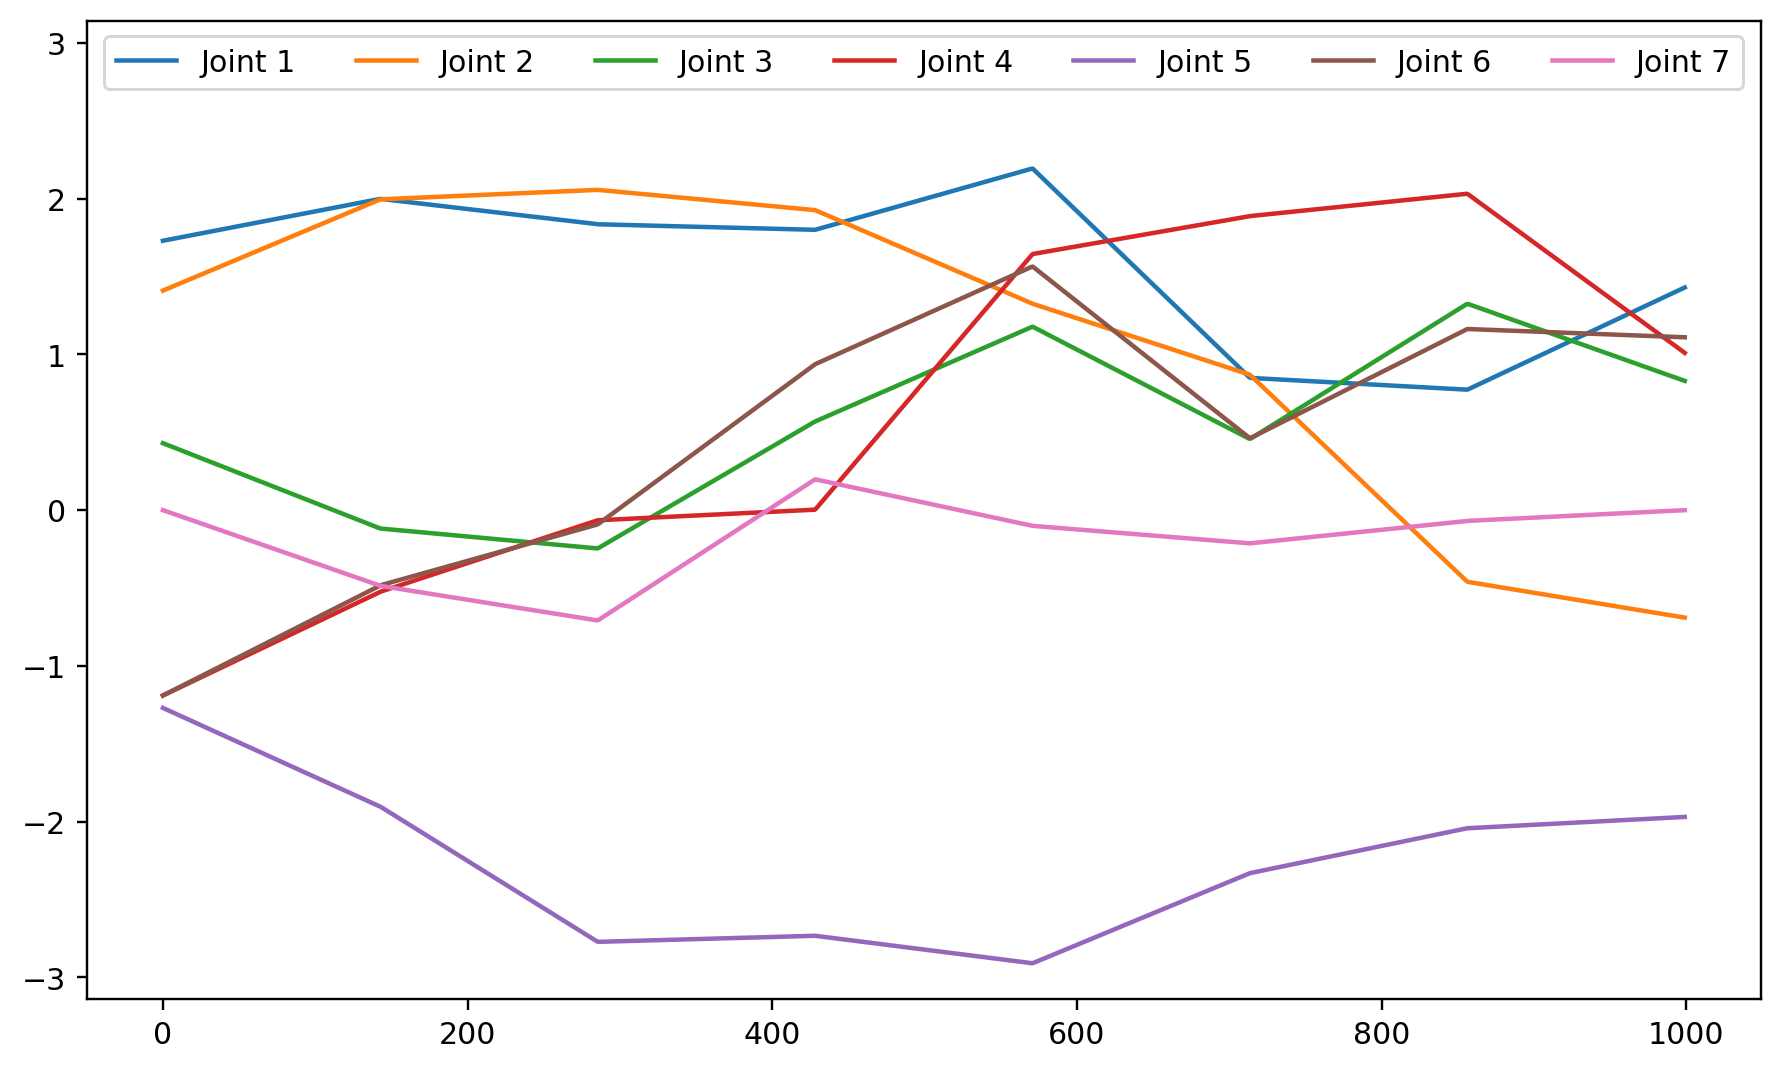

In [113]:
prm_traj= utils.PWLinTraj(prm_path, 5.0)
substeps = 1000
utils.plot(prm_traj, substeps, 1*substeps)
utils.animate(prm_traj, showres, substeps, 10*substeps)


In [ ]:
print(f'PRM path shape: {np.array(prm_path).shape}')
subsampled_prm_path = prm_path[1:-1]
print(f'PRM path shape subsampled for IRIS seed points: {np.array(subsampled_prm_path).shape}')

In [ ]:
RRT = rrt.RRT(start = target,
              goal = start,
              limits = limits,
              col_func_handle=col_func_handle,
              max_extend_length=0.5,
              extend_steps=0.05,
              init_goal_sample_rate=0.03,
              goal_sample_rate_scaler=0.6,
              verbose = True, 
              plotcallback = None)

_, rrt_path = RRT.run(10000)
print(f'RRT path length: {len(rrt_path)}')

0
it: 0 distance to target:  3.906 goalsample prob:  0.030
it: 1 distance to target:  3.640 goalsample prob:  0.030
it: 6 distance to target:  3.490 goalsample prob:  0.030
it: 8 distance to target:  3.348 goalsample prob:  0.030
it: 9 distance to target:  3.220 goalsample prob:  0.030
it: 18 distance to target:  3.142 goalsample prob:  0.030
it: 25 distance to target:  2.990 goalsample prob:  0.030
it: 56 distance to target:  2.926 goalsample prob:  0.030
it: 109 distance to target:  2.892 goalsample prob:  0.030
it: 114 distance to target:  2.842 goalsample prob:  0.030
it: 698 distance to target:  2.774 goalsample prob:  0.030
it: 732 distance to target:  2.624 goalsample prob:  0.030
1000
it: 1531 distance to target:  2.514 goalsample prob:  0.030
it: 1985 distance to target:  2.426 goalsample prob:  0.030
2000
it: 2017 distance to target:  2.176 goalsample prob:  0.030
it: 2113 distance to target:  2.148 goalsample prob:  0.030
3000
it: 3968 distance to target:  1.743 goalsample p

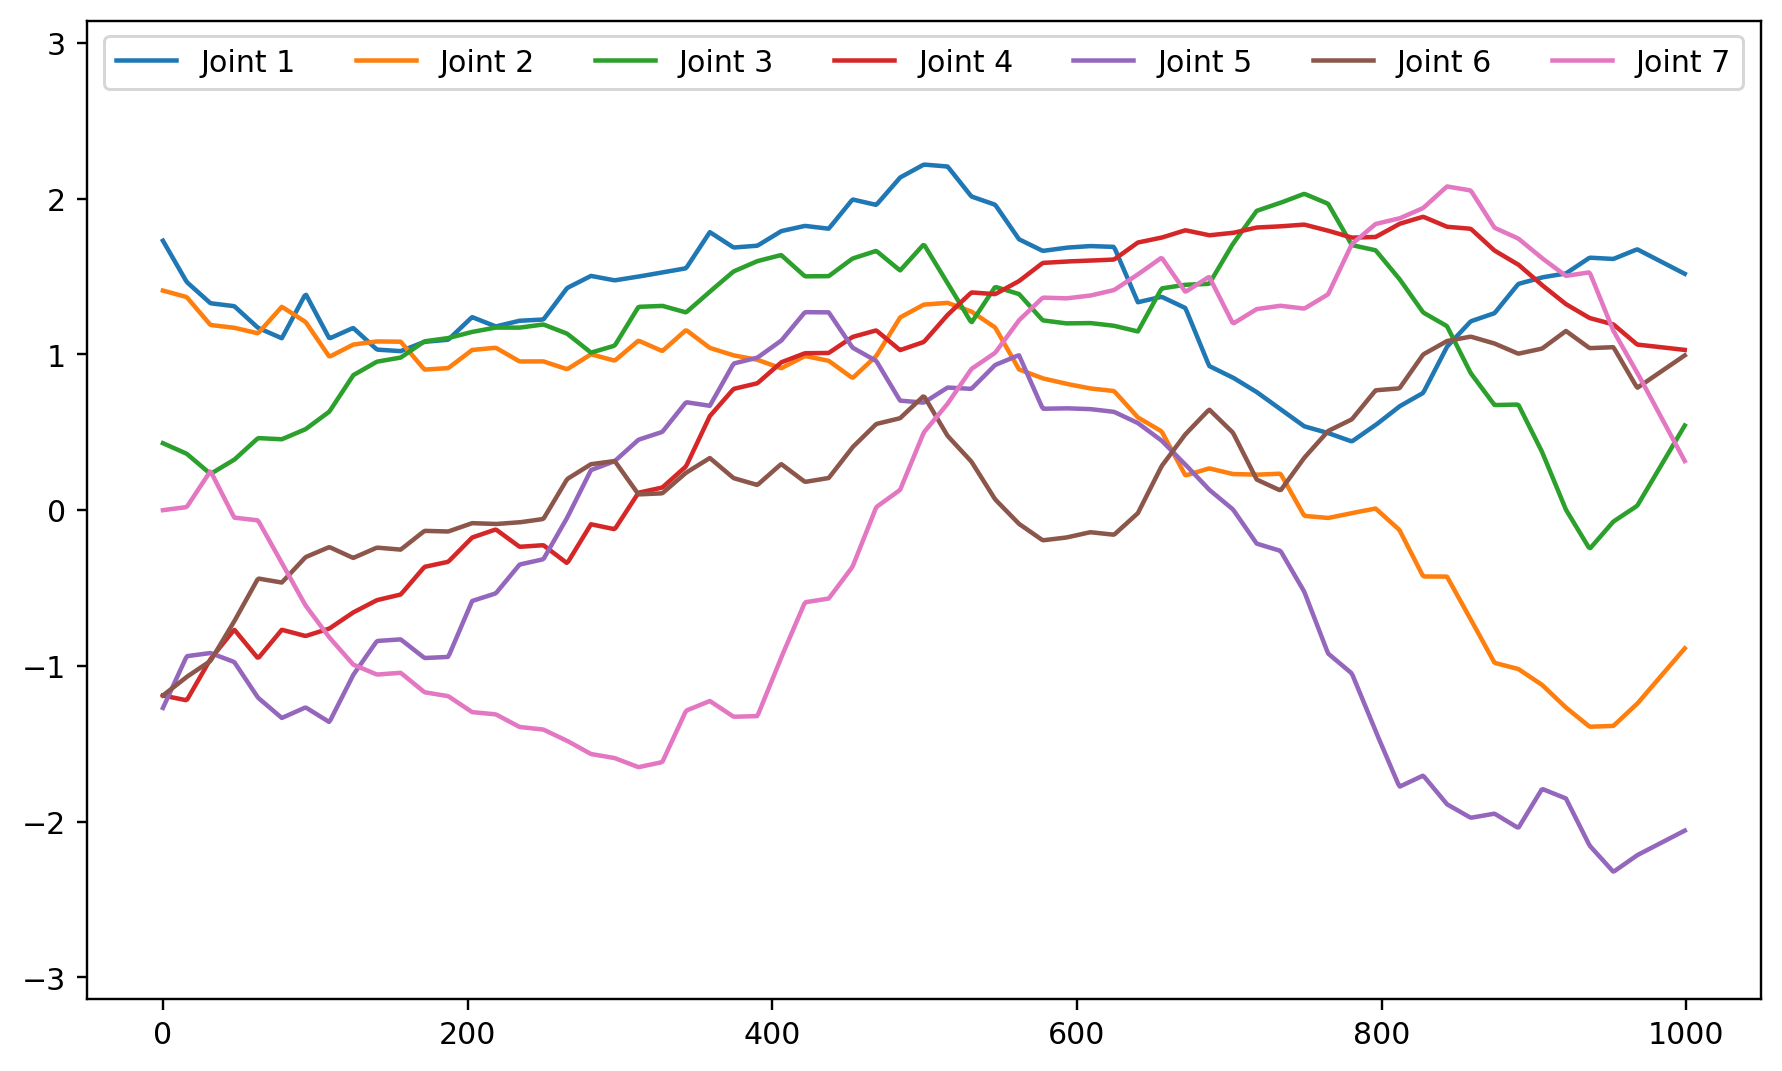

In [119]:
rrt_traj= utils.PWLinTraj(rrt_path, 5.0)
substeps = 1000
utils.animate(rrt_traj, showres, substeps, 5*substeps)
utils.plot(rrt_traj, substeps, 1*substeps)

In [ ]:
print(f'RRT path shape: {np.array(rrt_path).shape}')
subsampled_rrt_path = rrt_path[1:-1:10]
print(f'RRT path shape subsampled for IRIS seed points: {np.array(subsampled_rrt_path).shape}')

In [ ]:
def do_iris(q_seed, iris_options):
    start_time = time.time()
    hpoly = IrisInConfigurationSpace(plant, plant_context, q_seed, iris_options)
    ellipse = hpoly.MaximumVolumeInscribedEllipsoid()
    print("Time: %6.2f \tVolume: %6.2f \tCenter:" % (time.time() - start_time, ellipse.Volume()),
          ellipse.center(), flush=True)
    return ellipse, hpoly

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 50
iris_options.enable_ibex = False

regions = []
ellipses = []
its = 40
# seed_points = rrt_path
# seed_points = [start] + subsampled_rrt_path + [target]
seed_points = [start] + subsampled_prm_path + [target]
# seed_points = [start, target]


# for point in seed_points:
#     ell, reg = do_iris(point, iris_options)
#     regions.append(reg)
#     ellipses.append(ell)
    
# for it in range(its):
#     print(f'Iteration {it}/{its-1}')
#     #rejection sampling to get initial feasible point 
#     found = False
#     while not found:
#         t = np.random.rand(len(limits[0]))
#         q_samp = (1-t)*limits[0] + t*limits[1]
#         found = (col_func_handle(q_samp)==0.0)
#     print("point found: ", q_samp)
#     ell, reg = do_iris(q_samp, iris_options)
#     if ell.Volume() < 1000.0:
#         regions.append(reg)
#         ellipses.append(ell)
        
#         set_joint_angles(ell.center())
#         tf = plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(6)))
#         mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
#         mat.reflectivity = 1.0
#         vis['centers']['points' + str(it)].set_object(
#                     meshcat.geometry.Sphere(0.02), mat)
#         vis['centers']['points' + str(it)].set_transform(tf.GetAsMatrix4())

it = 0
for point in seed_points:
    ell, reg = do_iris(point, iris_options)
    
    if ell.Volume() < 1000.0:
        regions.append(reg)
        ellipses.append(ell)
        
        set_joint_angles(ell.center())
        tf = plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(6)))
        mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
        mat.reflectivity = 1.0
        vis['centers']['points' + str(it)].set_object(
                    meshcat.geometry.Sphere(0.02), mat)
        vis['centers']['points' + str(it)].set_transform(tf.GetAsMatrix4())
    it += 1

In [22]:
start_time = time.time()
spp = BsplineTrajectoryThroughUnionOfHPolyhedra(start, target, regions)
spp.set_max_velocity(.8 * np.ones(7))
spp.set_extra_control_points_per_region(2)

print(spp.num_regions())
traj = spp.Solve()
print(time.time() - start_time)
print(traj)

print(traj.start_time())
print(traj.end_time())
#visualize
maxit = 60
pts = []
for it in range(maxit):
    print(f'Iteration {it}/{maxit-1}')
    pts.append(traj.value(it*traj.end_time()/maxit))
    mat = meshcat.geometry.MeshLambertMaterial(color=0xFFF812)
    mat.reflectivity = 1.0
    set_joint_angles(pts[-1].reshape(-1,))
    tf= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(3)))
   
     
    mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
    mat.reflectivity = 1.0
    vis['traj']['points' + str(it)].set_object(
                meshcat.geometry.Sphere(0.02), mat)
    vis['traj']['points' + str(it)].set_transform(
                meshcat.transformations.translation_matrix(tf.translation()))
    

NameError: name 'regions' is not defined

In [ ]:
pts = []
for it in range(100):
    pts.append(traj.value(it*traj.end_time()/maxit))
    mat = meshcat.geometry.MeshLambertMaterial(color=0xFFF812)
    mat.reflectivity = 1.0
    set_joint_angles(pts[-1].reshape(-1,))
    tf= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(3)))
   
     
    mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
    mat.reflectivity = 1.0
    vis['traj']['points' + str(it)].set_object(
                meshcat.geometry.Sphere(0.02), mat)
    vis['traj']['points' + str(it)].set_transform(
                meshcat.transformations.translation_matrix(tf.translation()))

In [ ]:
# traj
substeps = 1000
utils.animate(traj, showres, substeps, 5*substeps)
utils.plot(traj, substeps, 1*substeps)

In [ ]:
# Manual reversal of IRIS trajectory

import matplotlib.pyplot as plt

#loop
idx = 0
going_fwd = True
time_points BsplineTrajectoryThroughUnionOfHPolyhedra= np.linspace(0, traj.end_time(), substeps) 

for _ in range(substeps):
    #print(idx)
    q = traj.value(time_points[substeps-idx-1])
    showres(q.reshape(-1,))
    if going_fwd:
        if idx + 1 < substeps:
            idx += 1
        else:
            going_fwd = False
            idx -=1
    else:
        if idx-1 >= 0:
            idx -=1
        else:
            going_fwd = True
            idx +=1


#loop
idx = 0
going_fwd = True
time_points = np.linspace(0, traj.end_time(), substeps) 
traj_list = []

for _ in range(substeps):
    #print(idx)
    traj_list.append(traj.value(time_points[substeps-idx-1]).reshape(-1,))
    if going_fwd:
        if idx + 1 < substeps:
            idx += 1
        else:
            going_fwd = False
            idx -=1
    else:
        if idx-1 >= 0:
            idx -=1
        else:
            going_fwd = True
            idx +=1

traj_arr = np.array(traj_list)

fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=72*3)
data_dims = traj_arr.shape[1]
for joint_idx in range(data_dims):
    ax.plot(np.arange(len(traj_arr[:,joint_idx])),traj_arr[:,joint_idx], label=f'Joint {joint_idx+1}')
ax.legend(loc='upper center', ncol=data_dims)
ax.set_ylim([-np.pi, np.pi])
plt.show()

In [ ]:
import spp


In [ ]:
from pydrake.geometry.optimization import 
